# UK Electricity Consumption Forecast - Time Series Analysis

The general framework we will use to carryout the time series forecasting analysis is as follows:

### 1. **Data Wrangling: Understanding the Dataset**
- Load our dataset into a dataset.
- Visualize the data to understand its pattern (e.g., using Matplotlib or Seaborn in Python). - Look for seasonality, trends, and potential outliers.
- Check for missing data and decide how we want to handle them (e.g., interpolation, forward-fill, or dropping).


### 2. **EDA: Decomposition of the Series**
Using the package `statsmodels.tsa.seasonal` in Python, we will decompose our time series into:
- Trend component
- Seasonal component
- Residual component

This gives us insights into the nature of the patterns in our data.

### 3. **Stationarity**
Most time series forecasting methods assume that the underlying time series is stationary, which means statistical properties like mean, variance, etc., are constant over time.

- Test for stationarity using the Dickey-Fuller test (`adfuller` function from `statsmodels.tsa.stattools`) and Kwiatkowski-Phillips-Schmidt-Shin test (`KPSS`function from `statsmodels.tsa.stattools`).
- If the series is non-stationary, we can make it stationary by differencing or taking the log, etc.

### 4. **Selecting a Model**
Below are the models we will use to forecast electricity demand in the UK:

- **ARIMA** (AutoRegressive Integrated Moving Average): A popular model for time series forecasting. We'll need to find optimal parameters (p,d,q) for the model. We can use tools like `auto_arima` in the `pmdarima` library to find the best parameters.

- **SARIMA** (Seasonal Autoregressive Integrated Moving Average). It's a statistical model used for forecasting time series data that exhibit seasonality.

- **Prophet**: Developed by Facebook, it's useful for datasets with strong seasonal patterns and multiple seasonality.

### 5. **Training and Validation**
- Split the dataset into a training set and a validation (or test) set. The training set will be used to train the model, while the validation set will be used to test its performance.
- Fit the selected model to the training data.
- Forecast for the validation period and compare the forecasted values with the actual values.

### 6. **Model Evaluation**
Use metrics like Mean Absolute Percentage Error (MAPE), Root Mean Squared Error (RMSE), or Mean Absolute Error (MAE) to measure the accuracy of our forecasts.

### 7. **Forecasting**
Once satisfied with the model's performance on the validation set, we can use the entire dataset to train the model and then forecast future consumption or demand.

### 8. **Post-processing**
Some models might give forecasts that need post-processing. For example, if we log-transformed our data, we'll need to reverse the transformation on our forecasts.

### Load relevant libraries

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.seasonal import seasonal_decompose  # Decomposition
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

### Load Data Wranging & EDA Data

In [2]:
# Load data from Parquet
folder_path = '/Users/elevate/Documents/Springboard Data Science/GitHub Repos/Capstone_3_Project/2. Data_Wrangling_EDA'

data_loaded = pd.read_parquet(f'{folder_path}/eda_output.parquet')

# Check first few rows to ensure data loaded correctly
data_loaded.head()

,settlement_date,settlement_period,period_hour,nd,tsd,england_wales_demand,embedded_wind_generation,embedded_wind_capacity,embedded_solar_generation,embedded_solar_capacity,non_bm_stor,pump_storage_pumping,ifa_flow,ifa2_flow,britned_flow,moyle_flow,east_west_flow,nemo_flow,is_holiday
0,2009-01-01 00:00:00,1,0:00:00,37910,38704,33939,54,1403,0,0,0,33,2002,0,0,-161,0,0,1
1,2009-01-01 00:30:00,2,0:30:00,38047,38964,34072,53,1403,0,0,0,157,2002,0,0,-160,0,0,1
2,2009-01-01 01:00:00,3,1:00:00,37380,38651,33615,53,1403,0,0,0,511,2002,0,0,-160,0,0,1
3,2009-01-01 01:30:00,4,1:30:00,36426,37775,32526,50,1403,0,0,0,589,1772,0,0,-160,0,0,1
4,2009-01-01 02:00:00,5,2:00:00,35687,37298,31877,50,1403,0,0,0,851,1753,0,0,-160,0,0,1


**Note**: Before proceeding with Prophet, you need to make sure the data is structured in a way Prophet expects. The Prophet model expects the dataframe to have columns named "ds" (for the date or datetime) and "y" (for the value you want to forecast).

In [3]:
# The settlement_date' is ds and the 'tsd' column is 'value'
data_prophet = data_loaded.rename(columns={'settlement_date': 'ds', 'tsd': 'y'})

# Check the first few rows
print(data_prophet.head())

                   ds  settlement_period period_hour     nd      y  \
0 2009-01-01 00:00:00                  1     0:00:00  37910  38704   
1 2009-01-01 00:30:00                  2     0:30:00  38047  38964   
2 2009-01-01 01:00:00                  3     1:00:00  37380  38651   
3 2009-01-01 01:30:00                  4     1:30:00  36426  37775   
4 2009-01-01 02:00:00                  5     2:00:00  35687  37298   

   england_wales_demand  embedded_wind_generation  embedded_wind_capacity  \
0                 33939                        54                    1403   
1                 34072                        53                    1403   
2                 33615                        53                    1403   
3                 32526                        50                    1403   
4                 31877                        50                    1403   

   embedded_solar_generation  embedded_solar_capacity  non_bm_stor  \
0                          0                  

### 4.0 Using Prophet Model

#### 4.1 Initialization

In [4]:
from prophet import Prophet

# Create a new Prophet Object
prophet_model = Prophet()

#### 4.2 Fit the model on only 2 columns: `ds` and `y`

In [5]:
# Fit the model to our data
prophet_model.fit(data_prophet[['ds', 'y']])

22:25:42 - cmdstanpy - INFO - Chain [1] start processing
22:27:42 - cmdstanpy - INFO - Chain [1] done processing


#### 4.3 Make Future Predictions

- To forecast with Prophet, we first have to create a dataframe with the dates for which we want a prediction.

In [6]:
# Make future dataframe for next 48 periods (considering 30 mins per period which equals 1 day)
future = prophet_model.make_future_dataframe(periods=48, freq='H')
forecast = prophet_model.predict(future)

**Note**:

We created a dataframe called future, that extends into the future for 48 periods on an hourly basis (since we have data every 30 minutes, this totals one day). Then, we make predictions for both the historical and future data.

#### 4.4 Plotting Future Predictions

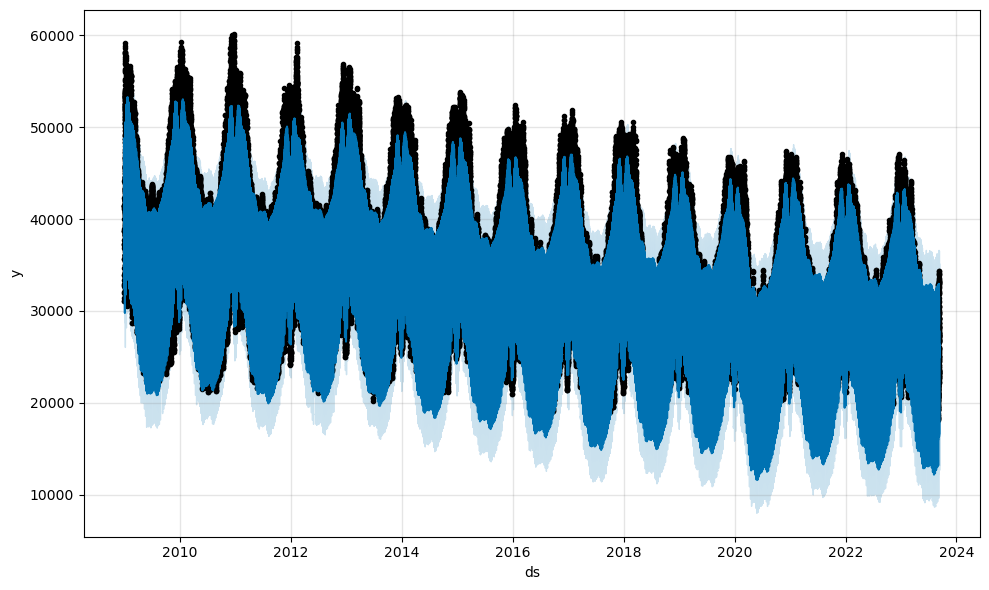

In [7]:
fig = prophet_model.plot(forecast)

**Note**:

This plots the original data (black dots), the model's predictions (blue line), and the uncertainty intervals of those predictions (shaded blue region).

#### 4.5 Inspecting Forecast Components

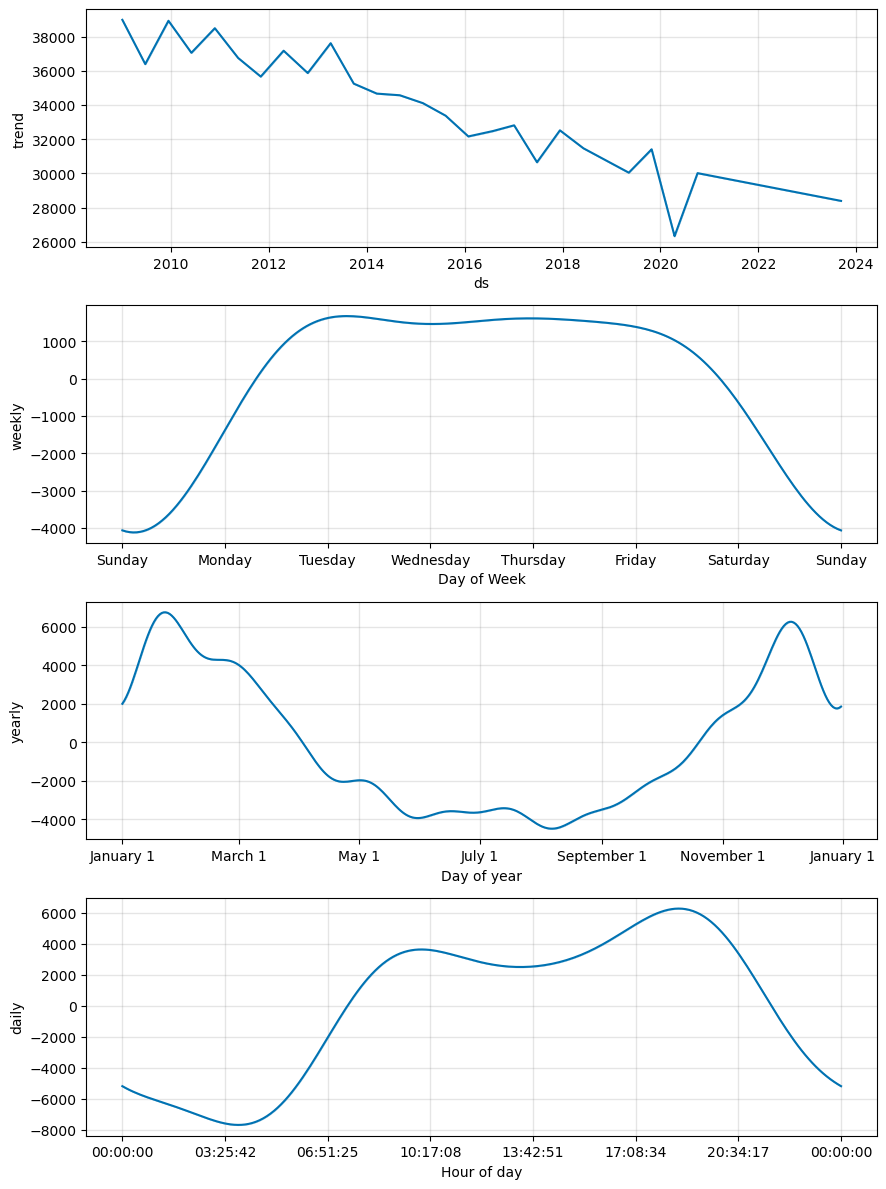

In [8]:
fig_components = prophet_model.plot_components(forecast)

### Model Results Interpretation

**Electricity Demand Forecasting with the Prophet Model: 2009 - 2023**

**Overview:**
We applied the Prophet model to predict the electricity demand from 2009 to 2023. Our observations from the forecast are detailed below.

**Trend Analysis:**
1. **General Demand Trend:** Over the span from 2009 to 2023, there's an observable trend of decreasing electricity demand. 
2. **Significant Dip in 2020:** A sharp decline was noticed in the year 2020, where the demand plummeted from 31,000 to 26,500 megawatts. Following this significant dip, there was a rebound as energy demand climbed back up to around 30,000 megawatts. Post this climb, we are currently witnessing a gradual decrease in demand, which is projected to settle around 28,000 megawatts in 2024.

**Weekly Analysis:**
1. **Sunday - The Low Demand Day:** Sundays manifest the lowest electricity demand in the week, with a demand deficit of around -4000 megawatts.
2. **Mid-week Consistency:** The days from Tuesday to Friday have a consistently higher demand, hovering around 1500 megawatts.
3. **Start and End of the Week:** Mondays see a demand closer to -1500 megawatts, while Saturdays are slightly better but still in the negative domain at -500 megawatts.

**Yearly Seasonal Analysis:**
1. **High Demand Months:** The months from January to March witness the highest electricity demands, ranging between 2,000 to 6,500 megawatts.
2. **Low Demand Phase:** A phase of reduced demand is observed from May to September, with demands oscillating between -4000 to 2000 megawatts.
3. **End-of-Year Surge:** There's a noticeable surge in demand starting from November, peaking in January, where demands rise again to the range of 2000 to 6000 megawatts.

**Daily Demand Distribution:**
1. **Peak Demand Hours:** The daily electricity demand peaks between 10:17:08 to 20:34:17. The demand is particularly high and concentrated between 17:08:34 and 20:34:17.
2. **Lowest Demand Hours:** In contrast, the least demand during the day is observed in the early hours, from 00:00:00 to 03:25:42.

**Conclusion:**
The Prophet model provided us with insightful observations about the electricity demand patterns over the years, weeks, and hours of the day. This analysis can be foundational for electricity providers and stakeholders to strategize their supply and infrastructure planning accordingly.